# Analyse CIGALE Results for NON-EMU sources

In [5]:
observatory = '/data/mfonseca/'
my_computer = '/home/polaris/Lab_Astro/data/'

directory = my_computer

## Import Libraries

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


import numpy as np
import pandas as pd

import math

# Astropy
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo

# CuPY
# import cupy as cp

# Seaborn
import seaborn as sns

## Defined Log10 of the properties

In [7]:
catalog_path = '/home/polaris/Lab_Astro/data/cigale/nonemu_data/nonemu_sample_1/results.fits'
catalog_table = Table.read(catalog_path)
catalog_pd = catalog_table.to_pandas()


catalog_pd= catalog_pd[catalog_pd['best.reduced_chi_square'] <= 5.0]


catalog_pd['bayes.sfh.sfr_permass'] = catalog_pd['bayes.sfh.sfr'] / catalog_pd['bayes.stellar.m_star']


# Calculate log10 of parameters
catalog_pd['log_stellar_mass'] = np.log10(catalog_pd['bayes.stellar.m_star'])
catalog_pd['log_sfr'] = np.log10(catalog_pd['bayes.sfh.sfr'])
catalog_pd['log_sfr_permass'] = np.log10(catalog_pd['bayes.sfh.sfr'] / catalog_pd['bayes.stellar.m_star'])
catalog_pd['log_metallicity'] = np.log10(catalog_pd['bayes.stellar.metallicity'])
catalog_pd['log_age'] = np.log10(catalog_pd['bayes.sfh.age'])
catalog_pd['log_Av_BC'] = np.log10(catalog_pd['bayes.attenuation.Av_BC'])

# Propagate errors for logs: Δ(log10 x) = Δx / (x * ln(10))
catalog_pd['log_stellar_mass_err'] = catalog_pd['bayes.stellar.m_star_err'] / (catalog_pd['bayes.stellar.m_star'] * np.log(10))
catalog_pd['log_sfr_err'] = catalog_pd['bayes.sfh.sfr_err'] / (catalog_pd['bayes.sfh.sfr'] * np.log(10))
catalog_pd['log_sfr_permass_err'] = np.sqrt(
    (catalog_pd['bayes.sfh.sfr_err'] / (catalog_pd['bayes.sfh.sfr'] * np.log(10)))**2 +
    (catalog_pd['bayes.stellar.m_star_err'] / (catalog_pd['bayes.stellar.m_star'] * np.log(10)))**2
)
catalog_pd['log_metallicity_err'] = catalog_pd['bayes.stellar.metallicity_err'] / (catalog_pd['bayes.stellar.metallicity'] * np.log(10))
catalog_pd['log_age_err'] = catalog_pd['bayes.sfh.age_err'] / (catalog_pd['bayes.sfh.age'] * np.log(10))
catalog_pd['log_Av_BC_err'] = catalog_pd['bayes.attenuation.Av_BC_err'] / (catalog_pd['bayes.attenuation.Av_BC'] * np.log(10))

## Main Sequence of Star Forming Galaxies

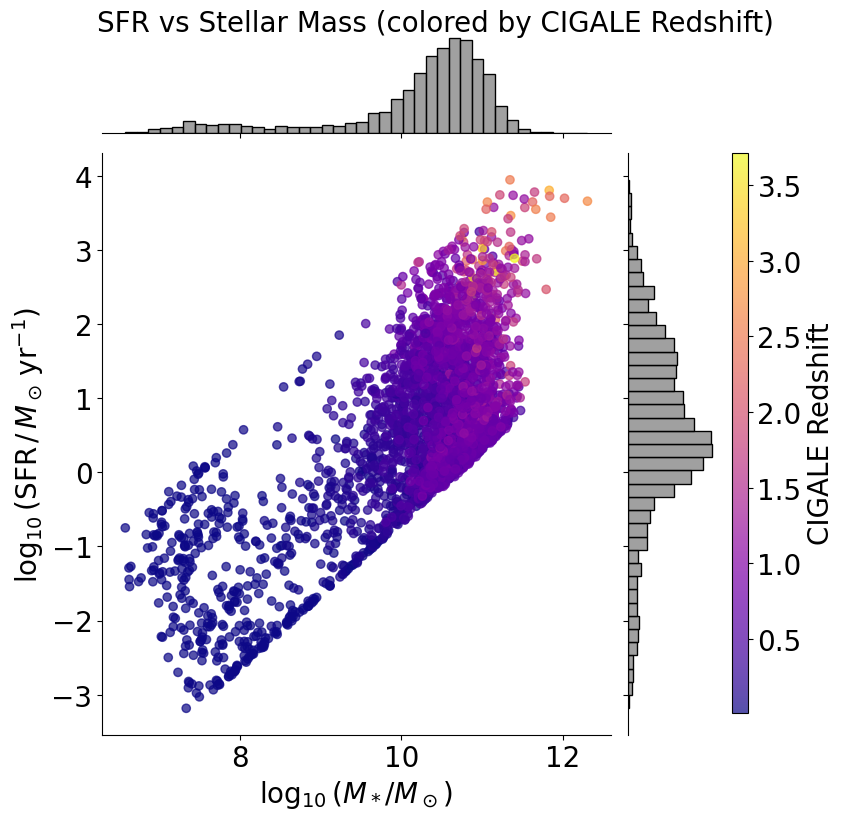

In [14]:
# Create the JointGrid
g = sns.JointGrid(
    data=catalog_pd,
    x='log_stellar_mass',
    y='log_sfr',
    height=8
)

# Main scatterplot with color by redshift
points = g.ax_joint.scatter(
    catalog_pd['log_stellar_mass'],
    catalog_pd['log_sfr'],
    c=catalog_pd['bayes.universe.redshift'],
    cmap='plasma',
    alpha=0.7
)

# Add marginal histograms
sns.histplot(
    data=catalog_pd,
    x='log_stellar_mass',
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y='log_sfr',
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

# Set axis labels and title with larger font
g.set_axis_labels(
    r'$\log_{10}(M_*/M_\odot)$',
    r'$\log_{10}({\rm SFR}\,/\,M_\odot\,{\rm yr}^{-1})$',
    fontsize=20
)
g.ax_joint.tick_params(axis='both', labelsize=20)
g.ax_marg_x.tick_params(labelsize=20)
g.ax_marg_y.tick_params(labelsize=20)

# Title
g.fig.suptitle('SFR vs Stellar Mass (colored by CIGALE Redshift)', fontsize=20)
g.fig.subplots_adjust(top=0.95, right=0.85)  # Shrink plot area to make room for colorbar

# Add external colorbar with larger label and ticks
cbar_ax = g.fig.add_axes([0.87, 0.1, 0.02, 0.7])
cbar = g.fig.colorbar(points, cax=cbar_ax)
cbar.set_label('CIGALE Redshift', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.show()

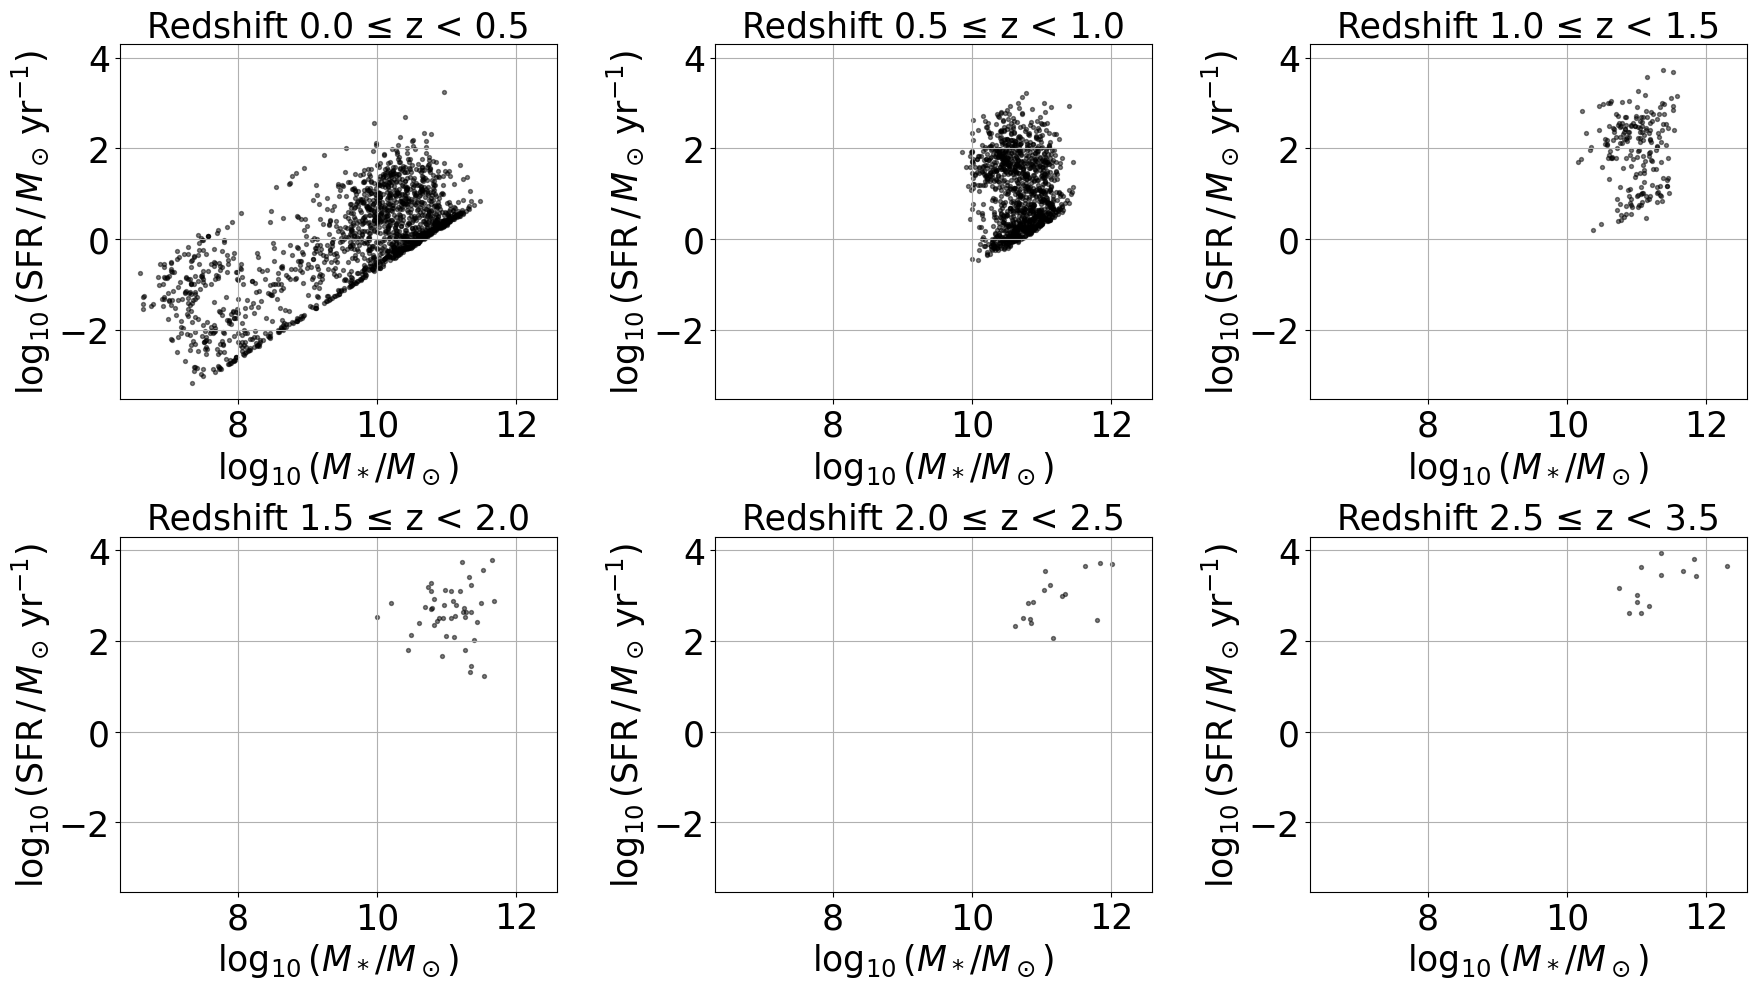

In [10]:
# This plot uses CIGALE redshifts

bins = [(0.0, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, 3.5)]

# Determine global axis limits
x_min, x_max = catalog_pd['log_stellar_mass'].min(), catalog_pd['log_stellar_mass'].max()
y_min, y_max = catalog_pd['log_sfr'].min(), catalog_pd['log_sfr'].max()

# Optional: Add padding
x_pad = 0.05 * (x_max - x_min)
y_pad = 0.05 * (y_max - y_min)
xlim = (x_min - x_pad, x_max + x_pad)
ylim = (y_min - y_pad, y_max + y_pad)

# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Loop over redshift bins and create scatter plots
for i, (zmin, zmax) in enumerate(bins):
    ax = axes[i]
    zmask = (catalog_pd['bayes.universe.redshift'] >= zmin) & (catalog_pd['bayes.universe.redshift'] < zmax)
    subset = catalog_pd[zmask]

    ax.scatter(
        subset['log_stellar_mass'],
        subset['log_sfr'],
        color='black',
        s=8,
        alpha=0.5
    )
    
    ax.set_title(f'Redshift {zmin} ≤ z < {zmax}', fontsize=25)
    ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$', fontsize=25)
    ax.set_ylabel(r'$\log_{10}({\rm SFR}\,/\,M_\odot\,{\rm yr}^{-1})$', fontsize=25)
    ax.tick_params(labelsize=25)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(True)


# Hide the 6th (unused) subplot
#axes[-1].axis('off')

plt.tight_layout()
plt.savefig("/home/polaris/Lab_Astro/relationship_nonemu.png", dpi=72, bbox_inches='tight')
plt.show()